In [1]:
# CNN_assignment by Sanghveena Jondhle

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

Motivation: To create a multiclass classification model using a custom convolutional neural network in tensorflow

Data Summary:

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:

1. Actinic keratosis
2. Basal cell carcinoma
3. Dermatofibroma
4. Melanoma
5. Nevus
6. Pigmented benign keratosis
7. Seborrheic keratosis
8. Squamous cell carcinoma
9. Vascular lesion


# **Importing Skin Cancer Data**

# **Importing all the important libraries**









In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
root_path = '/content/gdrive/MyDrive/CNN_assignment/Skin_cancer_data_store'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [5]:
os.listdir(data_dir_train)

['vascular lesion',
 'squamous cell carcinoma',
 'dermatofibroma',
 'basal cell carcinoma',
 'melanoma',
 'seborrheic keratosis',
 'actinic keratosis',
 'pigmented benign keratosis',
 'nevus']

In [6]:
os.listdir(data_dir_test)

['vascular lesion',
 'nevus',
 'dermatofibroma',
 'melanoma',
 'actinic keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'pigmented benign keratosis',
 'basal cell carcinoma']

In [7]:
import glob
image_count_train = len(list(glob.glob(str(data_dir_train) + '/**/*.jpg')))
print(image_count_train)
image_count_test = len(list(glob.glob(str(data_dir_test) + '/**/*.jpg')))
print(image_count_test)

2239
118


Load using keras.preprocessing
Let's load these images off disk using the helpful image_dataset_from_directory utility.

# Create a dataset
Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

In [9]:
!python --version

Python 3.10.12


In [10]:
!pip install tensorflow_datasets

In [11]:
from tensorflow.keras.utils import image_dataset_from_directory

Use 80% of the images for training, and 20% for validation.

In [12]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [13]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [14]:
# @title Visualize distribution of classes in the training dataset.
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

Class  No. of Image
0             vascular lesion           139
1     squamous cell carcinoma           181
2              dermatofibroma            95
3        basal cell carcinoma           376
4                    melanoma           438
5        seborrheic keratosis            77
6           actinic keratosis           114
7  pigmented benign keratosis           462
8                       nevus           357

In [15]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# Visualize the data

Todo, create a code to visualize one instance of all the nine classes present in the dataset

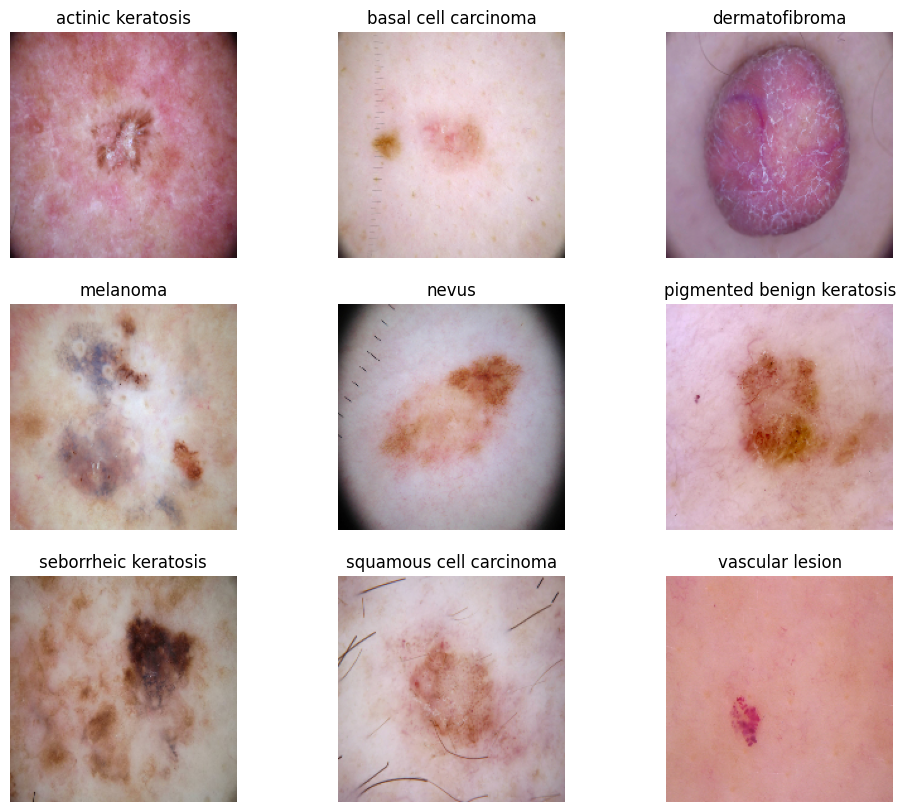

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
for i in range(len(class_names)):
  filtered_ds = train_ds.filter(lambda x,l:tf.math.equal(l[0], i))
  for image, label in filtered_ds.take(1):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image[0].numpy().astype('uint8'))
    plt.title(class_names[label.numpy()[0]])
    plt.axis('off')

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create the model

Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [18]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

In [19]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), # First Convulation Layer
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'), #Second Convulation Layer
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),#Third Convulation Layer
  layers.MaxPooling2D(),
  layers.Flatten(), #Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
  layers.Dense(128, activation='relu'),#Dense Layer
  layers.Dense(num_classes)
])


In [20]:
print(num_classes)

9


# Compile the model

Choose an appropirate optimiser and loss function for model training

In [21]:
### Todo, choose an appropirate optimiser and loss function

# optimizer = 'adam'
# loss_fn = "binary_crossentropy"
# model.compile(optimizer=optimizer,
#               loss=loss_fn,
#               metrics=['accuracy'])

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

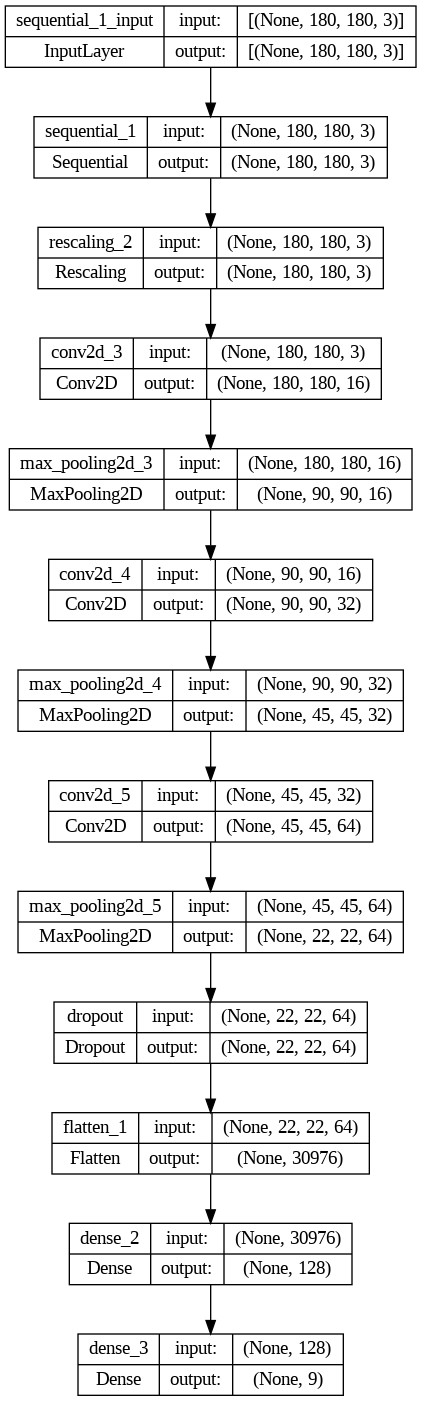

In [35]:
from tensorflow.keras.utils import plot_model
plot_model(model,to_file='model_plot.png',show_shapes=True, show_layer_names=True)

# Train the model

In [36]:
epochs = 20
batch_size = 32

history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 66s 1s/step - loss: 1.2440 - accuracy: 0.5513 - val_loss: 1.3548 - val_accuracy: 0.5459
Epoch 2/20
56/56 [==============================] - 63s 1s/step - loss: 1.2296 - accuracy: 0.5541 - val_loss: 1.3138 - val_accuracy: 0.5481
Epoch 3/20
56/56 [==============================] - 69s 1s/step - loss: 1.2017 - accuracy: 0.5631 - val_loss: 1.3308 - val_accuracy: 0.5034
Epoch 4/20
56/56 [==============================] - 71s 1s/step - loss: 1.1381 - accuracy: 0.5910 - val_loss: 1.2691 - val_accuracy: 0.5548
Epoch 5/20
56/56 [==============================] - 65s 1s/step - loss: 1.1373 - accuracy: 0.5915 - val_loss: 1.2884 - val_accuracy: 0.5548
Epoch 6/20
56/56 [==============================] - 66s 1s/step - loss: 1.1418 - accuracy: 0.5871 - val_loss: 1.2840 - val_accuracy: 0.5526
Epoch 7/20
56/56 [==============================] - 65s 1s/step - loss: 1.1342 - accuracy: 0.6004 - val_loss: 1.3465 - val_accuracy: 0.5324
Epoch 8/20
56/56 [==

# Visualizing training results

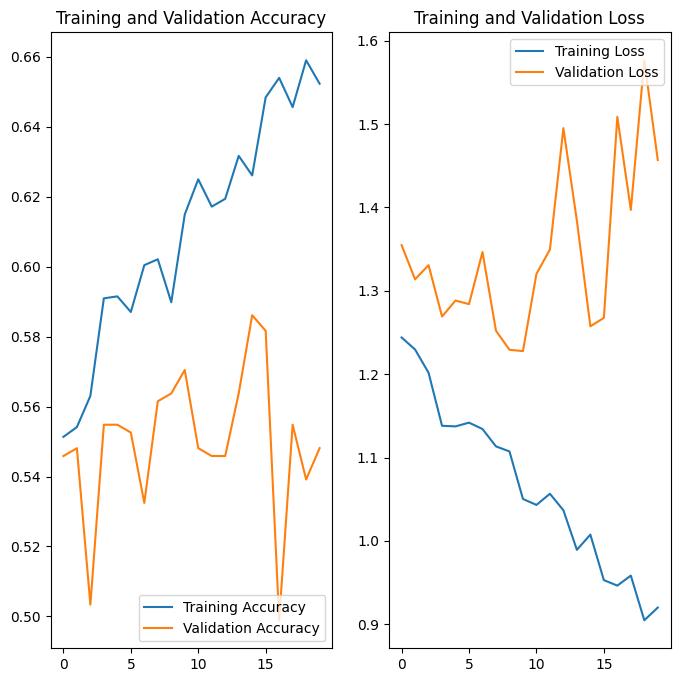

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Model Overfit or Underfit?

In [37]:

loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


# Thus we can clearly that model Overfit and we need to chose right data augumentation strategy

14/14 [==============================] - 3s 219ms/step - loss: 1.4569 - accuracy: 0.5481
Accuracy:  0.68359375
Validation Accuracy:  0.5480984449386597
Loss:  0.8582639694213867
Validation Loss 1.4569334983825684


Findings:
1] We can clearly observe a drastic difference between Traning and Validation Accuracy, which indicates that the model has overfitted
2] Also we can observe that the validation accuracy the model has achieved is below 55 %
Overall we need to apply techniques like Data Augmentation and Dropout to handle the overfitting issue of the model

# Data Augumentation

In [33]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
#As the training accuracy(92.35%)  is higher than validation accuracy(53.47%), it is an indication of overfitting. It means model is verfitting to the traing data.
# Your code goes here
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


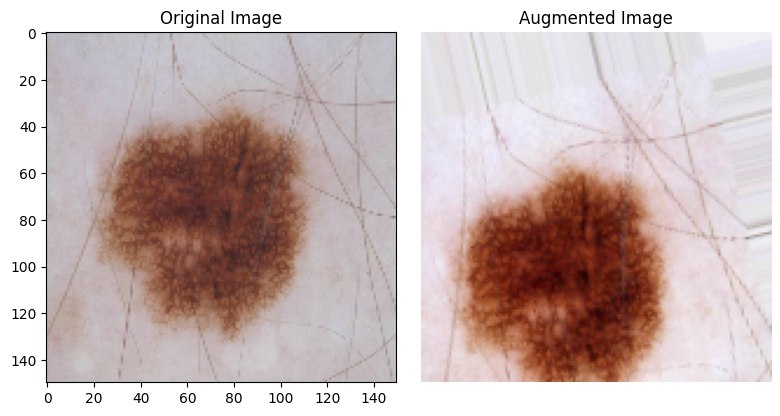

In [34]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
# Load a sample training image
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
img_path= "/content/gdrive/MyDrive/CNN_assignment/Skin_cancer_data_store/Train/nevus/ISIC_0000019.jpg"
img = image.load_img(img_path, target_size=(150, 150))  # Adjust target size as needed
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')

# Apply augmentation transformations
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(1, 2, 2)
    plt.imshow(image.array_to_img(batch[0]))
    plt.title('Augmented Image')
    plt.axis('off')
    i += 1
    if i >= 1:  # Number of augmentation instances to generate
        break  # Break the loop to prevent infinite generation

plt.tight_layout()
plt.show()

In [26]:
# data_augmentation = keras.Sequential(
#   [
#     layers.RandomFlip("horizontal",
#                       input_shape=(img_height,
#                                   img_width,
#                                   3)),
#     layers.RandomRotation(0.1),
#     layers.RandomZoom(0.1),
#   ]
# )

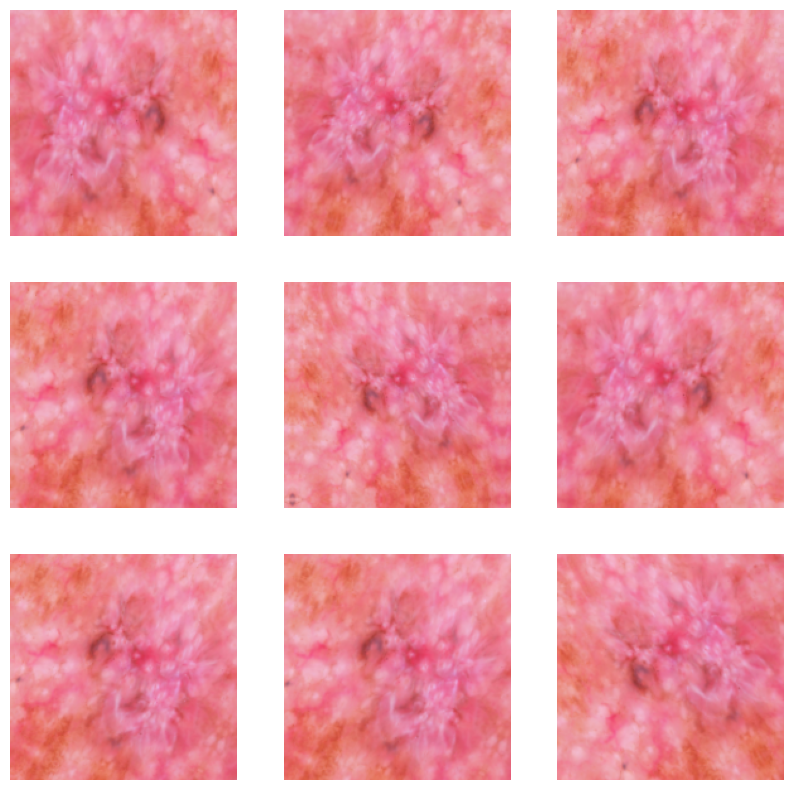

In [39]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

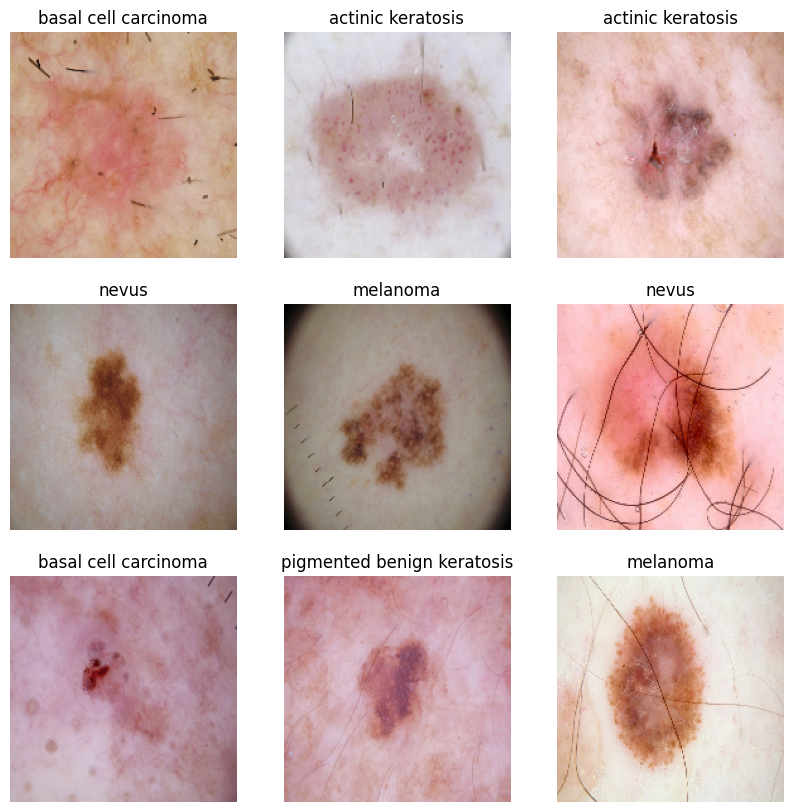

In [40]:
# # visualize how your augmentation strategy works for one instance of training image.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Create the model, compile and train the model

In [45]:
#Data augumentation strategy.


input_shape = (img_height,img_width,3)


data_augmentation = tf.keras.Sequential([
  #Randomly flip each image horizontally and vertically.
  layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),

  #Randomly rotate each image.
  layers.experimental.preprocessing.RandomRotation(0.1),

  #Randomly zoom each image during training.
  layers.experimental.preprocessing.RandomZoom(0.1),

  #Randomly contrast each image during training.
#  layers.experimental.preprocessing.RandomTranslation(0.1,0.1)
])

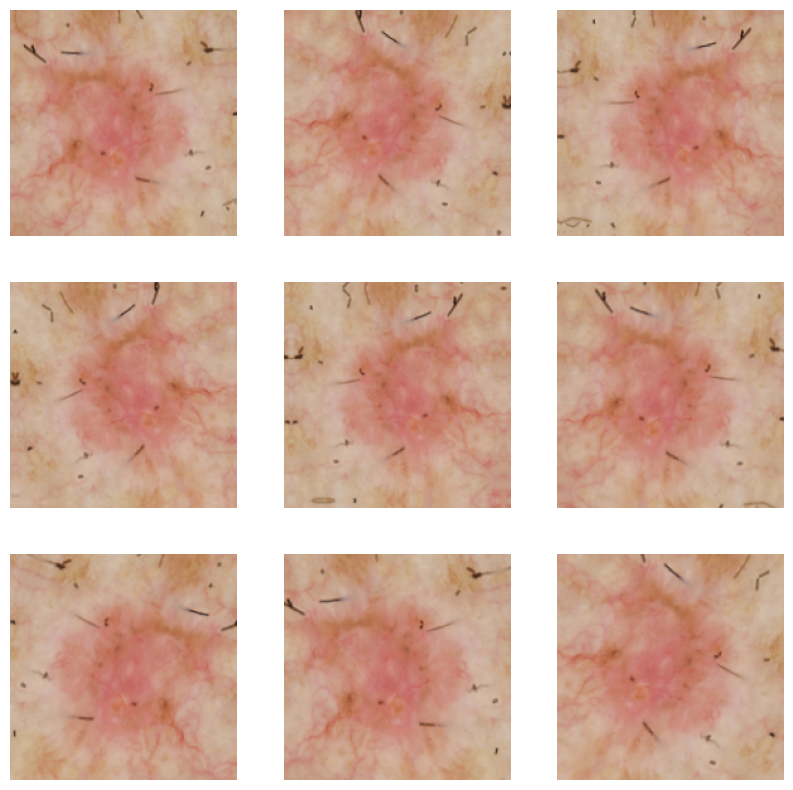

In [46]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

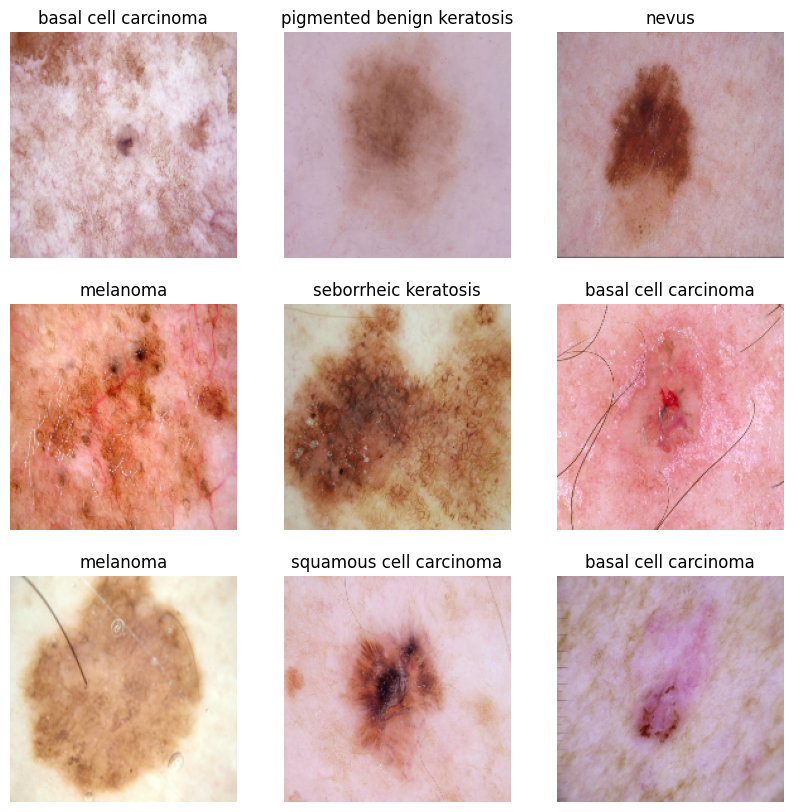

In [47]:
# visualize how your augmentation strategy works for one instance of training image.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [48]:
model2 = Sequential([
  data_augmentation,  #Augmentation layer
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),#First Convulation Layer
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),#Second Convulation Layer
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'), #Third Convulation Layer
  layers.MaxPooling2D(),
  layers.Dropout(0.2),#Dropout layer with 20% Fraction of the input units to drop.
  layers.Flatten(),
  layers.Dense(128, activation='relu'),#Dense Layer
  layers.Dense(num_classes)
])

# Compiling the model

In [49]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [50]:
sample_input = np.random.rand(1, img_height, img_width, 3)
model2(sample_input)

<tf.Tensor: shape=(1, 9), dtype=float32, numpy=
array([[-1.6354964e-04,  5.0119750e-05, -1.4499789e-04, -3.4979248e-04,
        -7.5469143e-04, -6.4238813e-04,  4.3303630e-04,  1.7533472e-04,
         8.3869585e-05]], dtype=float32)>

# Training the model

In [52]:
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  batch_size=batch_size,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 64s 1s/step - loss: 1.8346 - accuracy: 0.3343 - val_loss: 1.8248 - val_accuracy: 0.2886
Epoch 2/20
56/56 [==============================] - 71s 1s/step - loss: 1.7233 - accuracy: 0.3795 - val_loss: 1.6563 - val_accuracy: 0.4452
Epoch 3/20
56/56 [==============================] - 65s 1s/step - loss: 1.5987 - accuracy: 0.4180 - val_loss: 1.5697 - val_accuracy: 0.4295
Epoch 4/20
56/56 [==============================] - 64s 1s/step - loss: 1.5456 - accuracy: 0.4682 - val_loss: 1.4632 - val_accuracy: 0.4631
Epoch 5/20
56/56 [==============================] - 65s 1s/step - loss: 1.4819 - accuracy: 0.4777 - val_loss: 1.5876 - val_accuracy: 0.4765
Epoch 6/20
56/56 [==============================] - 65s 1s/step - loss: 1.4559 - accuracy: 0.4961 - val_loss: 1.5040 - val_accuracy: 0.4653
Epoch 7/20
56/56 [==============================] - 65s 1s/step - loss: 1.4456 - accuracy: 0.4911 - val_loss: 1.4580 - val_accuracy: 0.5056
Epoch 8/20
56/56 [==

# Visualizing the results

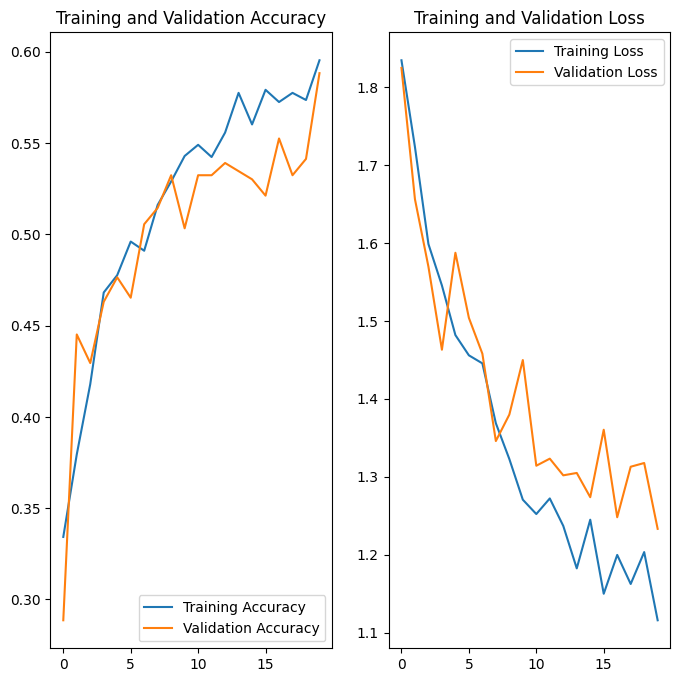

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Findings:
As we can see that now the Training and Validation accuracy are almost in the same level and the highest accuracy achieved is around 62% , this shows the impact of how performing Data Augmentation can improve the model performance
But we can still try to increase the accuracy of the model

# Find the distribution of classes in the training dataset.
Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [54]:
!pip install glob2
import glob2

path_list = [x for x in glob2.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob2.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict_original = dict(zip(path_list, lesion_list))
df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
df

Path            Label
0     /content/gdrive/MyDrive/CNN_assignment/Skin_ca...  vascular lesion
1     /content/gdrive/MyDrive/CNN_assignment/Skin_ca...  vascular lesion
2     /content/gdrive/MyDrive/CNN_assignment/Skin_ca...  vascular lesion
3     /content/gdrive/MyDrive/CNN_assignment/Skin_ca...  vascular lesion
4     /content/gdrive/MyDrive/CNN_assignment/Skin_ca...  vascular lesion
...                                                 ...              ...
2234  /content/gdrive/MyDrive/CNN_assignment/Skin_ca...            nevus
2235  /content/gdrive/MyDrive/CNN_assignment/Skin_ca...            nevus
2236  /content/gdrive/MyDrive/CNN_assignment/Skin_ca...            nevus
2237  /content/gdrive/MyDrive/CNN_assignment/Skin_ca...            nevus
2238  /content/gdrive/MyDrive/CNN_assignment/Skin_ca...            nevus

[2239 rows x 2 columns]

Todo: Write your findings here:
- Which class has the least number of samples?
- Which classes dominate the data in terms proportionate number of samples?

Class=8, n=139 (6.208%)
Class=7, n=181 (8.084%)
Class=2, n=95 (4.243%)
Class=1, n=376 (16.793%)
Class=3, n=438 (19.562%)
Class=6, n=77 (3.439%)
Class=0, n=114 (5.092%)
Class=5, n=462 (20.634%)
Class=4, n=357 (15.945%)


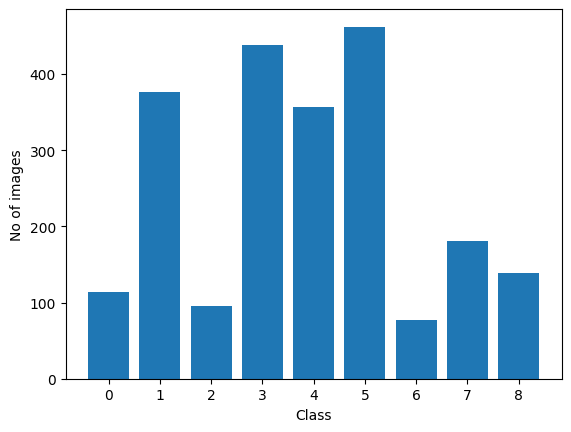

In [55]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter

X, y = df['Path'], df['Label']
y = LabelEncoder().fit_transform(y)
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

plt.bar(counter.keys(), counter.values())
plt.xticks([i for i in range(9)])
plt.xlabel("Class")
plt.ylabel("No of images")
plt.show()


- Which class has the least number of samples?¶
Ans] From the above bar chart we can see that the class with label 6 () has the least number of samples

- Which classes dominate the data in terms proportionate number of samples?
Ans] We can observe that of all the class, class with label 5() has the most number of samples

Todo: Rectify the class imbalance

In [56]:
!pip install Augmentor

To use Augmentor, the following general procedure is followed:

1. Instantiate a Pipeline object pointing to a directory containing your initial image data set.
2. Define a number of operations to perform on this data set using your Pipeline object.
3. Execute these operations by calling the Pipeline’s sample() method.

In [57]:
path_to_training_dataset="/content/gdrive/MyDrive/CNN_assignment/Skin_cancer_data_store/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i )
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_data_store/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B99B62C0490>: 100%|██████████| 500/500 [00:27<00:00, 18.13 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_data_store/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B99B6577640>: 100%|██████████| 500/500 [00:30<00:00, 16.51 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_data_store/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B99B6577550>: 100%|██████████| 500/500 [00:29<00:00, 16.80 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_data_store/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7B99B5A33E50>: 100%|██████████| 500/500 [01:52<00:00,  4.44 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_data_store/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7B99C1185AB0>: 100%|██████████| 500/500 [01:37<00:00,  5.11 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_data_store/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B99C1350940>: 100%|██████████| 500/500 [00:23<00:00, 21.08 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_data_store/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7B99B66B34C0>: 100%|██████████| 500/500 [00:51<00:00,  9.62 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_data_store/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B99C1185DE0>: 100%|██████████| 500/500 [00:25<00:00, 19.49 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin_cancer_data_store/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B99B636BCA0>: 100%|██████████| 500/500 [00:23<00:00, 21.48 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [58]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [59]:
import glob

path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/CNN_assignment/Skin_cancer_data_store/Train/vascular lesion/output/vascular lesion_original_ISIC_0033135.jpg_b484a549-35e5-4855-a460-73d02dde8e06.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin_cancer_data_store/Train/vascular lesion/output/vascular lesion_original_ISIC_0033969.jpg_6c779a65-e0d2-4895-a6c5-30f3ee57d109.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin_cancer_data_store/Train/vascular lesion/output/vascular lesion_original_ISIC_0031901.jpg_fcbf956b-15aa-4d7d-81b8-776e0451ee67.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin_cancer_data_store/Train/vascular lesion/output/vascular lesion_original_ISIC_0030283.jpg_0335f2aa-fb55-4eea-b51f-352c33ac4eb0.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin_cancer_data_store/Train/vascular lesion/output/vascular lesion_original_ISIC_0031276.jpg_ac05e261-d618-40d2-a0cc-0346d675e8f5.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin_cancer_data_store/Train/vascular lesion/output/vascular lesion_o

In [60]:
import glob

path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in path_list]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [61]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [62]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

In [63]:
new_df = df2

In [64]:
new_df['Label'].value_counts()

Label
vascular lesion               500
squamous cell carcinoma       500
dermatofibroma                500
basal cell carcinoma          500
melanoma                      500
seborrheic keratosis          500
actinic keratosis             500
pigmented benign keratosis    500
nevus                         500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [65]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [66]:
data_dir_train="/content/gdrive/MyDrive/CNN_assignment/Skin_cancer_data_store/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
validation_split = 0.2,
subset = 'training',  # Todo choose the correct parameter value, so that only training data is refered to,,
image_size = (img_height, img_width),
batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [67]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
validation_split = 0.2,
subset = "validation",  # Todo choose the correct parameter value, so that only validation data is refered to,
image_size=(img_height, img_width),
batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [68]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),#First Convulation layer
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),#Second Convulation Layer
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),#Third Convulation Layer
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),#Flatten Layer
  layers.BatchNormalization() #Batch Normalization Layer
  layers.Dense(128, activation='relu'), #Dense Layer
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [69]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [ ]:

epochs = 30
history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/30
169/169 [==============================] - 270s 2s/step - loss: 1.9831 - accuracy: 0.2556 - val_loss: 1.6898 - val_accuracy: 0.3578
Epoch 2/30
169/169 [==============================] - 246s 1s/step - loss: 1.5373 - accuracy: 0.4217 - val_loss: 1.4644 - val_accuracy: 0.4410
Epoch 3/30
169/169 [==============================] - 245s 1s/step - loss: 1.4149 - accuracy: 0.4629 - val_loss: 1.3796 - val_accuracy: 0.4707
Epoch 4/30
169/169 [==============================] - 259s 2s/step - loss: 1.3202 - accuracy: 0.4954 - val_loss: 1.2437 - val_accuracy: 0.5308
Epoch 5/30
169/169 [==============================] - 241s 1s/step - loss: 1.2612 - accuracy: 0.5184 - val_loss: 1.1832 - val_accuracy: 0.5501
Epoch 6/30
169/169 [==============================] - 243s 1s/step - loss: 1.2196 - accuracy: 0.5321 - val_loss: 1.2536 - val_accuracy: 0.5249
Epoch 7/30
169/169 [==============================] - 238s 1s/step - loss: 1.1861 - accuracy: 0.5399 - val_loss: 1.2439 - val_accuracy: 0.5286

#### **Todo:**  Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Analyze your results here.

Findings:
We can infer that the Model is fit with a good enough accuracy for both Train and Validation Data of max accuracy around 85% Rectifying the Class Imbalance and performing Data augumentation on the dataset has resulted in a model with higher accuracy and overcoming overfitting This is a good model to be used to predict Skin Cancer using CNN